In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install python-igraph

     |████████████████████████████████| 3.2MB 5.2MB/s 


In [3]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import re
import igraph as ig
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier,VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [4]:
# Training set file
TRAIN_FILE = '/content/drive/My Drive/Colab Notebooks/train.txt'
TEST_FILE = '/content/drive/My Drive/Colab Notebooks/test-public.txt'
Total_edges_used_for_training_for_each_class = 50000
Submission_file_using_bagging_classifier = '/content/drive/My Drive/Colab Notebooks/submission_bagging.csv'
Submission_file_using_XGB_and_AGA = '/content/drive/My Drive/Colab Notebooks/submission_voting_XGB_ADA.csv'

In [5]:
def read_datafile(file, header = False):

    source_nodes = set()
    destination_dict = {}       # How many sources follow a given destination node 
    source_follow_count_dict = {}         # How many destination nodes does each source follow

    dataset = open(file)
    if header:
      next(dataset)

    # Creates a dictionary with destination values and count its frequencies. In addition, creates a set with all root nodes
    for lines in dataset:
        node_list = lines.strip().split('\t')
        source_nodes.add(node_list[0])
        
        for node in node_list[1:]:
            destination_dict[node] = destination_dict.get(node,0) + 1
        
        source_follow_count_dict[node_list[0]] = len(node_list[1:])

    return source_nodes, destination_dict, source_follow_count_dict

In [40]:
# Read training data 
source_nodes, destination_dict, source_follow_count_dict = read_datafile(TRAIN_FILE)

print ("Total Source nodes: %s" % (len(source_nodes)))
print ("Total Destination nodes: %s" % (len(destination_dict)))
print ("Total edges: %s" % (sum(source_follow_count_dict.values())))

Total Source nodes: 20000
Total Destination nodes: 4867136
Total edges: 24004361


In [7]:
def filter_destination_Nodes(destination_dict, min_followers = 10):

    new_destination_dict = {}

    # Filters the data by removing nodes that are being followed less than a threshold (default = 10)
    for key in destination_dict:
        if destination_dict[key] >= min_followers:
            new_destination_dict[key] = destination_dict[key]
    
    return new_destination_dict

In [8]:
new_destination_dict = filter_destination_Nodes(destination_dict,10)

print("Destination nodes after filter:  %s" % (len(new_destination_dict)))
print("Total nodes after filter: %s" % (len(new_destination_dict) + len(source_nodes)))

Destination nodes after filter:  394342
Total nodes after filter: 414342


In [9]:
#Add nodes if filtered which are in test set
test_source_nodes, test_destination_dict, test_source_follow_count_dict = read_datafile(TEST_FILE,True)
print("Total source nodes in test file:  %s" % (len(test_source_nodes)))

nodes_in_train_after_filtering = list(source_nodes) + list(set(new_destination_dict.keys()) - source_nodes)

nodes_in_test_file = list(test_source_nodes) + list(set(test_destination_dict.keys()) - test_source_nodes)

total_nodes = nodes_in_train_after_filtering + list(set(nodes_in_test_file) - set(nodes_in_train_after_filtering))
print("Total nodes (source + destination) to be used in training:  %s" % (len(total_nodes)))

Total source nodes in test file:  2000
Total nodes (source + destination) to be used in training:  401221


In [10]:
def build_index_for_unique_id(node_list):
    index = {}
    inv_index = {}

    for i, node in enumerate(node_list):
        index[i] = node
        inv_index[node] = i
    
    return index, inv_index

In [11]:
# Create an index and an inverted index, in order to have a unique Id for each node
index, inv_index = build_index_for_unique_id(total_nodes)
print("Length of index:  %s" % (len(index)))

Length of index:  401221


In [12]:
def BinarySearch(lys, val):
    first = 0
    last = len(lys)-1
    index = -1
    while (first <= last) and (index == -1):
        mid = (first+last)//2
        if lys[mid] == val:
            index = mid
        else:
            if val<lys[mid]:
                last = mid -1
            else:
                first = mid +1
    return index

In [13]:
def build_tuples(file, destination_dict, total_nodes, inv_index, max_neighbours=1000, Total_edges_used_for_training_of_each_class = 50000):
    
    tuples = []
    train_tuples = []

    total_nodes.sort()

    # In case a source node have more than 1000 followers, we only consider max_neighbours (default = 1000)
    with open(file) as train_data:
        for lines in tqdm(train_data):
            node_list = lines[:-1].split('\t')
            source_node = node_list[0]
            
            if len(node_list[1:]) > max_neighbours:
              # We rank the nodes based on the frequency
              rank = [-destination_dict[destnode] for destnode in node_list[1:]]              
              sort_function = np.argsort(rank)
              filtered_destination_list = np.array(node_list[1:])[sort_function]
              # print(filtered_destination_list)
            else:
              filtered_destination_list = node_list[1:]

            # We only keep the top 1000 nodes and create the tuples for them
            for dest_node in filtered_destination_list[0:max_neighbours]:
                if BinarySearch(total_nodes, dest_node) != -1:
                    tuples.append((inv_index[source_node], inv_index[dest_node]))
    
    if Total_edges_used_for_training_of_each_class:
        train_tuples = random.sample(tuples, Total_edges_used_for_training_of_each_class)
    
    return tuples, train_tuples

In [14]:
tuples, train_tuples = build_tuples(TRAIN_FILE, destination_dict, total_nodes, inv_index, max_neighbours=2000, Total_edges_used_for_training_of_each_class=Total_edges_used_for_training_for_each_class)

print ("All Tuples (source, destination): %s" % (len(tuples)))
print ("Random Train set Tuples (source, destination): %s" % (len(train_tuples)))

20000it [01:20, 247.23it/s]

All Tuples (source, destination): 6792218
Random Train set Tuples (source, destination): 1000


In [15]:
def build_igGraph(tuple_list, nodes):
    
    # Create a new igGraph object
    G = ig.Graph(directed = True)
    for node in nodes:
        G.add_vertex(node)
    
    G.add_edges(tuple_list)
                
    return G

In [16]:
graph = build_igGraph(tuples, index.keys())
print ("Graph Ready")
ig.summary(graph)

Graph Ready
IGRAPH DN-- 401221 6792218 -- 
+ attr: name (v)


In [17]:
def build_fakeEdge(G, source_nodes, inv_index, No_of_true_positive_edges, tuples):

  fake_tuple_list = []
  filtered_fake_tuple_list = []

  for i in tqdm(range(0,No_of_true_positive_edges)):

    n1 = inv_index[np.random.choice(list(source_nodes))] #node 1 from source list
    n2 = random.randint(0, len(inv_index.values()))   
    fake_tuple_list.append((n1,n2))

      
  filtered_fake_tuple_list = list(set(fake_tuple_list).difference(set(tuples)))
  
          
  return filtered_fake_tuple_list

In [18]:
fake_tuple_list = build_fakeEdge(graph, source_nodes,  inv_index, len(train_tuples), tuples)
print ("Fake Tuples:\t%s" % (len(fake_tuple_list)))

100%|██████████| 1000/1000 [00:04<00:00, 233.34it/s]


Fake Tuples:	999


In [19]:
def friends_measure(graph, all_node_1, all_node_2):
  
    count = 0
  
    for edges_node_1 in all_node_1:
        for edges_node_2 in all_node_2:
            if (edges_node_1 == edges_node_2) or graph.are_connected(edges_node_1, edges_node_2) or graph.are_connected(edges_node_2, edges_node_1):
                count+=1
                
    return count

In [20]:
def build_Features(G, edge_list):
  common_inbound_friends = []
  common_outbound_friends = []
  common_friends = []
  friend_measure = []
  preferential_attachment = []
  inverse_flag = []
  in_degree_node_1 = []
  in_degree_node_2 = []
  out_degree_node_1 = []
  out_degree_node_2 = []
  bi_degree_node_1 = []
  bi_degree_node_2 = []
  # shortest_paths = []
  # adamic_adar_index = []
  # jaccard_similarity_index = []
  # preferential_attachment_score = []
  # friend_tns = []
  # similarity_dice_in = []
  # similarity_dice_out = []
  # similarity_dice_combined =[]

  
  # similarity_dice_in = graph.similarity_dice(pairs=edge_list,mode=ig.IN)
  # similarity_dice_out = graph.similarity_dice(pairs=edge_list,mode=ig.OUT)
  # similarity_dice_combined = graph.similarity_dice(pairs=edge_list,mode=ig.ALL)


  for i, edge in tqdm(enumerate(edge_list)):
    node_1, node_2 = edge
    
    # Common calculations
    predecessor_of_node_1 = set(G.predecessors(node_1))
    successor_of_node_1 = set(G.successors(node_1))
    predecessor_of_node_2 = set(G.predecessors(node_2))
    successor_of_node_2 = set(G.successors(node_2))
    all_node_1 = predecessor_of_node_1.union(successor_of_node_1)
    all_node_2 = predecessor_of_node_2.union(successor_of_node_2)
    common_nodes = all_node_1.intersection(all_node_2)
    all_nodes = all_node_1.union(all_node_2)

    # Features
    inverse_flag.append(np.int(G.are_connected(node_2,node_1)))

    common_outbound_friends.append(len(successor_of_node_1.intersection(successor_of_node_2)))
    common_inbound_friends.append(len(predecessor_of_node_1.intersection(predecessor_of_node_2)))
    common_friends.append(len(all_node_1.union(all_node_2)))
    friend_measure.append(friends_measure(G, all_node_1,all_node_2))

    in_degree_node_1.append(len(predecessor_of_node_1))
    in_degree_node_2.append(len(predecessor_of_node_2))
    out_degree_node_1.append(len(successor_of_node_1))
    out_degree_node_2.append(len(successor_of_node_2))
    bi_degree_node_1.append(len(successor_of_node_1.intersection(predecessor_of_node_1)))
    bi_degree_node_2.append(len(successor_of_node_2.intersection(predecessor_of_node_2)))
    # shortest_paths.append(G.shortest_paths(source = node_1, target = node_2)[0][0])


    # adamic_adar = sum([1.0/math.log(graph.degree(v)) for v in common_nodes])
    # if len(all_nodes) == 0:
    #   jaccard_similarity = 0
    # else:
    #   jaccard_similarity = len(common_nodes)/ float(len(all_nodes))

    # if len(all_node_1) + len(all_node_2) == 1:
    #   friend = 0
    # else:
    #   friend =  round((1.0/(len(all_node_1) + len(all_node_2) - 1.0)),3)

    # preferential_attachment = len(all_node_1) * len(all_node_2)
    # adamic_adar_index.append(adamic_adar)
    # jaccard_similarity_index.append(jaccard_similarity)
    # preferential_attachment_score.append(preferential_attachment)
    # friend_tns.append(friend) 
  return common_inbound_friends, common_outbound_friends, common_friends, friend_measure, inverse_flag, in_degree_node_1, in_degree_node_2, out_degree_node_1, out_degree_node_2, bi_degree_node_1, bi_degree_node_2
  # return common_inbound_friends, common_outbound_friends, common_friends, friend_measure, inverse_flag, in_degree_node_1, in_degree_node_2, out_degree_node_1, out_degree_node_2, bi_degree_node_1, bi_degree_node_2, shortest_paths, adamic_adar_index, jaccard_similarity_index, preferential_attachment_score, friend_tns, similarity_dice_in, similarity_dice_out, similarity_dice_combined

In [21]:
full_tuple_list = train_tuples + fake_tuple_list
label = np.concatenate((np.ones(len(train_tuples), dtype=int), np.zeros(len(fake_tuple_list), dtype=int)))

# We create full list index
full_list_index = {}
full_list_inv_index = {}

for i, tuple in enumerate(full_tuple_list):
    full_list_index[i] = tuple
    full_list_inv_index[tuple] = i

print ("label list: %s" % (len(label)))
print ("Total Tuples list: %s" % (len(full_tuple_list)))

label list: 1999
Total Tuples list: 1999


In [22]:
#FEATURE Engineering

# We create a pandas dataframe with the training set tuples
ids = np.array(list(full_list_index.keys()))
source_destination_nodes = np.array(full_tuple_list)

common_inbound_friends, common_outbound_friends, common_friends, friend_measure, inverse_flag, in_degree_node_1, in_degree_node_2, out_degree_node_1, out_degree_node_2, bi_degree_node_1, bi_degree_node_2 = build_Features(graph, full_tuple_list)
# common_inbound_friends, common_outbound_friends, common_friends, friend_measure, inverse_flag, in_degree_node_1, in_degree_node_2, out_degree_node_1, out_degree_node_2, bi_degree_node_1, bi_degree_node_2, shortest_paths, adamic_adar_index, jaccard_similarity_index, preferential_attachment_score, friend_tns, similarity_dice_in, similarity_dice_out, similarity_dice_combined = build_Features(graph, full_tuple_list)

1999it [05:16,  6.32it/s] 


In [23]:
print("Length of common_inbound_friends : %s" %len(common_inbound_friends))
print("Length of common_outbound_friends : %s" %len(common_outbound_friends))
print("Length of common_friends : %s" %len(common_friends))
print("Length of friend_measure : %s" %len(friend_measure))
print("Length of inverse_flag : %s" %len(inverse_flag))
print("Length of in_degree_node_1 : %s" %len(in_degree_node_1))
print("Length of in_degree_node_2 : %s" %len(in_degree_node_2))
print("Length of out_degree_node_1 : %s" %len(out_degree_node_1))
print("Length of out_degree_node_2 : %s" %len(out_degree_node_2))
print("Length of bi_degree_node_1 : %s" %len(bi_degree_node_1))
print("Length of bi_degree_node_2 : %s" %len(bi_degree_node_2))
# print("Length of shortest_paths : %s" %len(shortest_paths))
# print("Length of adamic_adar_index : %s" %len(adamic_adar_index))
# print("Length of jaccard_similarity_index : %s" %len(jaccard_similarity_index))
# print("Length of preferential_attachment_score : %s" %len(preferential_attachment_score))
# print("Length of friend_tns : %s" %len(friend_tns))
# print("Length of similarity_dice_in : %s" %len(similarity_dice_in))
# print("Length of similarity_dice_out : %s" %len(similarity_dice_out))
# print("Length of similarity_dice_combined : %s" %len(similarity_dice_combined))

Length of common_inbound_friends : 1999
Length of common_outbound_friends : 1999
Length of common_friends : 1999
Length of friend_measure : 1999
Length of inverse_flag : 1999
Length of in_degree_node_1 : 1999
Length of in_degree_node_2 : 1999
Length of out_degree_node_1 : 1999
Length of out_degree_node_2 : 1999
Length of bi_degree_node_1 : 1999
Length of bi_degree_node_2 : 1999


In [24]:
d = {
    'ids': ids,
     'Source': source_destination_nodes[:,0],
     'destination': source_destination_nodes[:,1],
     'inverse_flag': inverse_flag,
     'common_inbound_friends' : common_inbound_friends,
     'common_outbound_friends' : common_outbound_friends,
     'common_friends' : common_friends,
     'friend_measure' : friend_measure,
     'in-degree source' : in_degree_node_1,
     'in-degree destination' : in_degree_node_2,
     'out-degree source' : out_degree_node_1,
     'out-degree destination' : out_degree_node_2,
     'bi-degree source' : bi_degree_node_1,
     'bi-degree destination' : bi_degree_node_2,
    #  'shortest paths' : shortest_paths,
    #  'Adamic adar index' : adamic_adar_index,
    #  'Jaccard Similarity index' : jaccard_similarity_index,
    #  'preferential_attachment_score' : preferential_attachment_score,
    #  'friend_tns' : friend_tns,
    #  'similarity dice in' : similarity_dice_in,
    #  'similarity dice combined' : similarity_dice_combined,
    #  'similarity dice out' : similarity_dice_out,
     'label' : label
     }

df = pd.DataFrame(data=d)

df

,ids,Source,destination,inverse_flag,common_inbound_friends,common_outbound_friends,common_friends,friend_measure,in-degree source,in-degree destination,out-degree source,out-degree destination,bi-degree source,bi-degree destination,label
0,0,14389,139164,0,0,0,527,535,41,8,503,0,25,0,1
1,1,19380,193201,0,0,0,916,2982,5,51,865,0,4,0,1
2,2,9302,232333,0,1,0,2014,2477,238,4,1999,0,226,0,1
3,3,19348,243716,0,21,0,2714,58392,873,129,2000,0,266,0,1
4,4,2630,201994,0,175,0,2577,275018,740,402,2000,0,386,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,1994,8046,201397,0,0,0,195,4,47,5,163,0,20,0,0
1995,1995,2961,333271,0,2,0,2890,535,2431,9,546,0,94,0,0
1996,1996,19249,399245,0,0,0,272,2,102,1,214,0,45,0,0
1997,1997,15607,134765,0,0,0,132,13,11,6,124,0,9,0,0


In [25]:
# We split the training set into train and a holdout set
df_train, df_holdout = train_test_split(df, test_size=0.3, random_state=42)

Y_train = df_train['label']
Y_holdout = df_holdout['label']
X_train = df_train.drop(['label', 'Source', 'destination', 'ids'], axis = 1)
X_holdout = df_holdout.drop(['label', 'Source', 'destination', 'ids'], axis = 1)

print ("Train set length: %s" % (len(df_train)))
print ("Holdout set length: %s" % (len(df_holdout)))

Train set length: 1399
Holdout set length: 600


In [26]:
X_train

,inverse_flag,common_inbound_friends,common_outbound_friends,common_friends,friend_measure,in-degree source,in-degree destination,out-degree source,out-degree destination,bi-degree source,bi-degree destination
557,0,2,0,2042,5392,133,41,2000,0,130,0
843,0,13,20,294,2079,47,84,178,79,30,37
1652,0,0,0,505,27,337,10,200,0,42,0
1555,0,0,0,2008,222,7,7,2000,0,6,0
1160,0,0,0,1172,51,48,3,1167,0,46,0
...,...,...,...,...,...,...,...,...,...,...,...
1130,0,0,0,15,0,14,1,0,0,0,0
1294,0,1,0,3667,594,2035,7,2000,0,374,0
860,0,19,0,2665,231922,57,731,2000,0,33,0
1459,0,0,0,85,5,70,15,0,0,0,0


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


Text(0.5, 0, 'n_estimators')

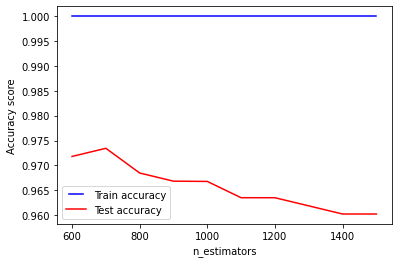

In [27]:
#For AdaBoost Classifier
n_estimators = np.linspace(600, 1500, 10, endpoint=True)

train_results = []
test_results = []

for i in tqdm(n_estimators):
    dt = AdaBoostClassifier(n_estimators=int(i))
    dt.fit(X_train, Y_train)    
    Y_prediction = dt.predict(X_train)

    #append results of accuracy
    train_results.append(roc_auc_score(Y_train, Y_prediction))
    
    #now again for test data
    Y_prediction = dt.predict(X_holdout)
    #append results of accuracy
    test_results.append(roc_auc_score(Y_holdout, Y_prediction))

from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
line1, = plt.plot(n_estimators, train_results, 'b', label='Train accuracy')
line2, = plt.plot(n_estimators, test_results, 'r', label= 'Test accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')

100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Text(0.5, 0, 'n_estimators')

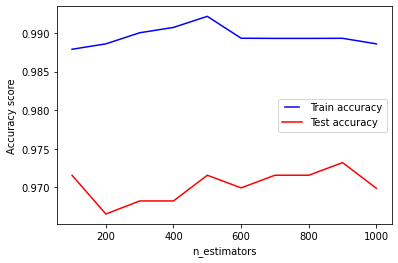

In [28]:
#For Random Forest
n_estimators = np.linspace(100, 1000, 10, endpoint=True)

train_results = []
test_results = []

for i in tqdm(n_estimators):
    dt = RandomForestClassifier(max_depth=8,n_estimators=int(i),n_jobs=-1)
    dt.fit(X_train, Y_train)    
    Y_prediction = dt.predict(X_train)

    #append results of accuracy
    train_results.append(roc_auc_score(Y_train, Y_prediction))
    
    #now again for test data
    Y_prediction = dt.predict(X_holdout)
    #append results of accuracy
    test_results.append(roc_auc_score(Y_holdout, Y_prediction))

from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
line1, = plt.plot(n_estimators, train_results, 'b', label='Train accuracy')
line2, = plt.plot(n_estimators, test_results, 'r', label= 'Test accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')

100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


Text(0.5, 0, 'Tree depth')

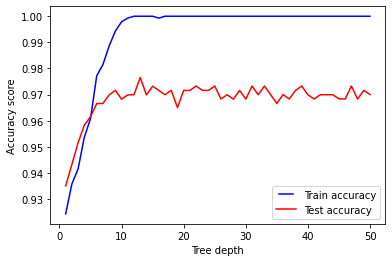

In [29]:
max_depths = np.linspace(1, 50, 50, endpoint=True)

train_results = []
test_results = []

for i in tqdm(max_depths):
    dt = RandomForestClassifier(max_depth=i,n_jobs=-1)
    dt.fit(X_train, Y_train)
    Y_prediction = dt.predict(X_train)    
    #append results of accuracy
    train_results.append(roc_auc_score(Y_train, Y_prediction))
    
    #now again for test data
    Y_prediction = dt.predict(X_holdout)
    errors = abs(Y_prediction - Y_holdout)
    #append results of accuracy
    test_results.append(roc_auc_score(Y_holdout, Y_prediction))


from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, test_results, 'r', label= 'Test accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')

In [30]:
import xgboost as xgb

names = [
         "K neighbor",
         "decision tree",
         "Logistic Regression",
         "AdaBoostClassifier",
         "xgboost",
         "RandomForestClassifier"
        ]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    LogisticRegression(),
    AdaBoostClassifier(),
    xgb.XGBClassifier(),
    RandomForestClassifier(),
] 

parameters = [
              {
                  'clf__n_neighbors':[15,20,25,30,35,40,45,50],
                  'clf__p':[1,2,3]
              },
              {
                  'clf__max_depth': [1,2,3,4,5],
                  'clf__max_features': [None, "auto", "sqrt", "log2"]
              },
              {
                    'clf__C':[0.01,0.1],
                    'clf__max_iter':[50,100,150,200],
                    'clf__penalty':['l2']
               
              },
              {
                  'clf__learning_rate' : [1],
                  'clf__n_estimators' : [400,450,500,600,700,800],
                  'clf__random_state' : [0],
                  'clf__algorithm' : ['SAMME.R']
              },
              {
                  'clf__learning_rate' : [0.001,0.01,0.1],
                  'clf__max_depth' : [2,3,4,5,6,7],
                  'clf__min_child_weight' : [1,2,3,4,5,6],
                  'clf__subsample' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
              },
              {
                  'clf__n_estimators' : [100,200,300,400],
                  'clf__max_depth' : [8]
              }
                
             ]
scaler = StandardScaler()
model_params_score = []
for name, classifier, params in zip(names, classifiers, parameters):
    steps=[('scaler', scaler), ('clf', classifier)]
    pipe = Pipeline(steps)
    print("Paprameters for the model are: ", pipe.get_params().keys())
    gs_clf = GridSearchCV(pipe, param_grid=params, cv=5,n_jobs=-1)
    gs_clf.fit(X_train, Y_train)
    Y_prediction = gs_clf.predict(X_holdout)
    model_params_score.append([classifier,roc_auc_score(Y_holdout, Y_prediction),gs_clf.best_params_])
    
    print("--------------------------------------------------------------------------")
    print("%s\n\n\t\tAUC score: %s" % (classifier , roc_auc_score(Y_holdout, Y_prediction)))

Paprameters for the model are:  dict_keys(['memory', 'steps', 'verbose', 'scaler', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'clf__algorithm', 'clf__leaf_size', 'clf__metric', 'clf__metric_params', 'clf__n_jobs', 'clf__n_neighbors', 'clf__p', 'clf__weights'])
--------------------------------------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

		AUC score: 0.8366212836899137
Paprameters for the model are:  dict_keys(['memory', 'steps', 'verbose', 'scaler', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'clf__ccp_alpha', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', 'clf__presort', 

In [31]:
model_params_score

[[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                       weights='uniform'),
  0.8366212836899137,
  {'clf__n_neighbors': 15, 'clf__p': 1}],
 [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='best'),
  0.9599888858016116,
  {'clf__max_depth': 4, 'clf__max_features': None}],
 [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
         

In [32]:
#get best index as a model
best_value =0.0
index = 0
for counter, info in enumerate(model_params_score):
    if(info[1]>best_value):
        best_value = info[1]
        index = counter
        
# retrained the model based on the best one for fitting the test data
classifier = model_params_score[index][0]
steps=[('scaler', scaler), ('clf', classifier)]
pipe = Pipeline(steps)  
pipe.set_params(**model_params_score[index][2])
pipe.fit(X_train, Y_train)
Y_prediction = pipe.predict(X_holdout)

print("--------------------------------------------------------------------------")
print("%s\n\n\t\tAUC score: %s" % (classifier , roc_auc_score(Y_holdout, Y_prediction)))

--------------------------------------------------------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

		AUC score: 0.9682411781050292


In [33]:
# voting using XGBOOST and ADABOOST 

scaler = StandardScaler()

voting_params_score=[]
eclf = VotingClassifier(estimators=[ 
    ('adaboost', AdaBoostClassifier()),
    ('xgb', xgb.XGBClassifier()),
    
    ], voting='soft'
)

#Use the key for the classifier followed by __ and the attribute
params = {'clf__adaboost__algorithm':['SAMME.R'],
          'clf__adaboost__learning_rate':[0.1,1],
          'clf__adaboost__n_estimators':[1000],
          
          
          'clf__xgb__booster':['gbtree'],
          'clf__xgb__eval': ['auc'],
          'clf__xgb__gamma':[0],
          'clf__xgb__lambda':[1],
          'clf__xgb__learning_rate': [0.1],
          'clf__xgb__max_depth':[100],
          'clf__xgb__min_child_weight':[10],
          'clf__xgb__subsample':[1]
         }

steps=[('scaler', scaler), ('clf', eclf)]
pipe = Pipeline(steps)
print("Paprameters for the model are: ", pipe.get_params().keys())

gs_clf = GridSearchCV(pipe, param_grid=params, cv=5,n_jobs=-1)
gs_clf.fit(X_train, Y_train)
Y_prediction = gs_clf.predict(X_holdout)
voting_params_score.append([eclf,roc_auc_score(Y_holdout, Y_prediction),gs_clf.best_params_])
    
print("--------------------------------------------------------------------------")
print("%s\n\n\t\tAUC score: %s" % (eclf , roc_auc_score(Y_holdout, Y_prediction)))

Paprameters for the model are:  dict_keys(['memory', 'steps', 'verbose', 'scaler', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'clf__estimators', 'clf__flatten_transform', 'clf__n_jobs', 'clf__voting', 'clf__weights', 'clf__adaboost', 'clf__xgb', 'clf__adaboost__algorithm', 'clf__adaboost__base_estimator', 'clf__adaboost__learning_rate', 'clf__adaboost__n_estimators', 'clf__adaboost__random_state', 'clf__xgb__base_score', 'clf__xgb__booster', 'clf__xgb__colsample_bylevel', 'clf__xgb__colsample_bynode', 'clf__xgb__colsample_bytree', 'clf__xgb__gamma', 'clf__xgb__learning_rate', 'clf__xgb__max_delta_step', 'clf__xgb__max_depth', 'clf__xgb__min_child_weight', 'clf__xgb__missing', 'clf__xgb__n_estimators', 'clf__xgb__n_jobs', 'clf__xgb__nthread', 'clf__xgb__objective', 'clf__xgb__random_state', 'clf__xgb__reg_alpha', 'clf__xgb__reg_lambda', 'clf__xgb__scale_pos_weight', 'clf__xgb__seed', 'clf__xgb__silent', 'clf__xgb__subsample', 'clf__xgb__verbosity'])
----------------

In [34]:
# We read the test data
test_edge_list = []

with open(TEST_FILE) as test_data:
    for i , lines in enumerate(test_data):
        
        if i == 0:                              # Skips the header
            continue;
        
        node_list = lines[:-1].split('\t')
        test_edge_list.append((inv_index[node_list[1]], inv_index[node_list[2]]))

common_inbound_friends, common_outbound_friends, common_friends, friend_measure, inverse_flag, in_degree_node_1, in_degree_node_2, out_degree_node_1, out_degree_node_2, bi_degree_node_1, bi_degree_node_2 = build_Features(graph, test_edge_list)
# common_inbound_friends, common_outbound_friends, common_friends, friend_measure, inverse_flag, in_degree_node_1, in_degree_node_2, out_degree_node_1, out_degree_node_2, bi_degree_node_1, bi_degree_node_2, shortest_paths, adamic_adar_index, jaccard_similarity_index, preferential_attachment_score, friend_tns, similarity_dice_in, similarity_dice_out, similarity_dice_combined = build_Features(graph, test_edge_list)

d_test = {
     'inverse_flag': inverse_flag,
     'common_inbound_friends' : common_inbound_friends,
     'common_outbound_friends' : common_outbound_friends,
     'common_friends' : common_friends,
     'friend_measure' : friend_measure,
     'in-degree source' : in_degree_node_1,
     'in-degree destination' : in_degree_node_2,
     'out-degree source' : out_degree_node_1,
     'out-degree destination' : out_degree_node_2,
     'bi-degree source' : bi_degree_node_1,
     'bi-degree destination' : bi_degree_node_2,
    #  'shortest paths' : shortest_paths,
    #  'Adamic adar index' : adamic_adar_index,
    #  'Jaccard Similarity index' : jaccard_similarity_index,
    #  'preferential_attachment_score' : preferential_attachment_score,
    #  'friend_tns' : friend_tns,
    #  'similarity dice in' : similarity_dice_in,
    #  'similarity dice combined' : similarity_dice_combined,
    #  'similarity dice out' : similarity_dice_out,
     }


df_test = pd.DataFrame(data=d_test)
df_test

2000it [01:18, 25.32it/s]


,inverse_flag,common_inbound_friends,common_outbound_friends,common_friends,friend_measure,in-degree source,in-degree destination,out-degree source,out-degree destination,bi-degree source,bi-degree destination
0,0,0,0,23,8,3,10,11,0,1,0
1,0,0,0,56,17,11,6,47,0,8,0
2,0,2,0,206,283,77,14,147,0,29,0
3,0,0,0,391,119,12,9,381,0,11,0
4,0,0,0,17,0,4,2,13,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,37,0,15,0,33,0,11,0
1996,0,0,0,109,0,47,1,83,0,22,0
1997,0,0,0,23,2,4,1,20,0,2,0
1998,0,0,0,38,0,6,0,37,0,5,0


In [35]:
# retrained the model based on the best one for fitting the test data
classifier = eclf
steps=[('scaler', scaler), ('clf', classifier)]
pipe = Pipeline(steps)  
pipe.set_params(**voting_params_score[0][2])
pipe.fit(X_train, Y_train)
Y_prediction = pipe.predict(X_holdout)
y_predicted = pipe.predict_proba(df_test)[:,1]
y_predicted
#

array([0.23885701, 0.23684216, 0.62491048, ..., 0.23959268, 0.23902469,
       0.23369316])

In [36]:
# construct submission file
Id = [i for i in range(1, 2001)]
data = {"Id":Id, "Predicted":y_predicted}
df_submit = pd.DataFrame(data)
df_submit.to_csv(Submission_file_using_XGB_and_AGA, index = False, header=True)

In [37]:
# voting using RandomForest, KNeighborsClassifier and BaggingClassifier 

voting_params_score=[]
eclf = VotingClassifier(estimators=[ 
    ('randomForest', RandomForestClassifier()),
    ('knn', KNeighborsClassifier()),
    ('bagging',BaggingClassifier()),
    
    ], voting='soft'
)

#Use the key for the classifier followed by __ and the attribute
params = {
              'clf__randomForest__n_estimators' : [300],
              'clf__randomForest__max_depth' : [8],
          
              'clf__knn__n_neighbors':[5,10,15],
              'clf__knn__p':[2],
        
              'clf__bagging__n_estimators' : [10,50,100],
               
         }

steps=[('scaler', scaler), ('clf', eclf)]
pipe = Pipeline(steps)
print("Paprameters for the model are: ", pipe.get_params().keys())

gs_clf = GridSearchCV(pipe, param_grid=params, cv=5,n_jobs=-1)
gs_clf.fit(X_train, Y_train)
Y_prediction = gs_clf.predict(X_holdout)
voting_params_score.append([eclf,roc_auc_score(Y_holdout, Y_prediction),gs_clf.best_params_])
    
print("--------------------------------------------------------------------------")
print("%s\n\n\t\tAUC score: %s" % (eclf , roc_auc_score(Y_holdout, Y_prediction)))

Paprameters for the model are:  dict_keys(['memory', 'steps', 'verbose', 'scaler', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'clf__estimators', 'clf__flatten_transform', 'clf__n_jobs', 'clf__voting', 'clf__weights', 'clf__randomForest', 'clf__knn', 'clf__bagging', 'clf__randomForest__bootstrap', 'clf__randomForest__ccp_alpha', 'clf__randomForest__class_weight', 'clf__randomForest__criterion', 'clf__randomForest__max_depth', 'clf__randomForest__max_features', 'clf__randomForest__max_leaf_nodes', 'clf__randomForest__max_samples', 'clf__randomForest__min_impurity_decrease', 'clf__randomForest__min_impurity_split', 'clf__randomForest__min_samples_leaf', 'clf__randomForest__min_samples_split', 'clf__randomForest__min_weight_fraction_leaf', 'clf__randomForest__n_estimators', 'clf__randomForest__n_jobs', 'clf__randomForest__oob_score', 'clf__randomForest__random_state', 'clf__randomForest__verbose', 'clf__randomForest__warm_start', 'clf__knn__algorithm', 'clf__knn__leaf_

In [38]:
# retrained the model based on the best one for fitting the test data
classifier = eclf
steps=[('scaler', scaler), ('clf', classifier)]
pipe = Pipeline(steps)  
pipe.set_params(**voting_params_score[0][2])
pipe.fit(X_train, Y_train)
Y_prediction = pipe.predict(X_holdout)
y_predicted = pipe.predict_proba(df_test)[:,1]
y_predicted
#

array([5.48823549e-04, 1.30034125e-03, 4.56362427e-01, ...,
       1.09193251e-03, 9.52300454e-05, 4.09328652e-04])

In [39]:
# construct submission file
Id = [i for i in range(1, 2001)]
data = {"Id":Id, "Predicted":y_predicted}
df_submit = pd.DataFrame(data)
df_submit.to_csv(Submission_file_using_bagging_classifier, index = False, header=True)